## Installing Dependencies

In [3]:
!pip install gymnasium[box2d] stable-baselines3[extra] moviepy matplotlib

## Set up CarRacing-v0 with Monitor and DummyVecEnv

In [4]:
import os
import gymnasium as gym
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import DummyVecEnv

# Ensure log directory
os.makedirs("../logs", exist_ok=True)

# Create monitored vectorized CarRacing-v3 environment
env = gym.make("CarRacing-v3", render_mode="rgb_array")
env = Monitor(env, filename="../logs/ppo_monitor.csv")
env = DummyVecEnv([lambda: env])

## PPO Training for driftCTRL

In [5]:
from stable_baselines3 import PPO

# Define PPO agent with CNN policy (required for image input)
model = PPO(
    policy="CnnPolicy",
    env=env,
    verbose=1,
    tensorboard_log="./ppo_tensorboard/"  # Optional: logs for TensorBoard
)

# Train the agent (test run: 100k steps)
model.learn(total_timesteps=150_000)

# Save the trained model to /models
model.save("../models/ppo_driftctrl")


Using cuda device
Wrapping the env in a VecTransposeImage.
Logging to ./ppo_tensorboard/PPO_7
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -53.3    |
| time/              |          |
|    fps             | 102      |
|    iterations      | 1        |
|    time_elapsed    | 19       |
|    total_timesteps | 2048     |
---------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | -54.1        |
| time/                   |              |
|    fps                  | 91           |
|    iterations           | 2            |
|    time_elapsed         | 44           |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0062432406 |
|    clip_fraction        | 0.0455       |
|    clip_range           | 0.2          |
|    en

## Reward per Episode Plot

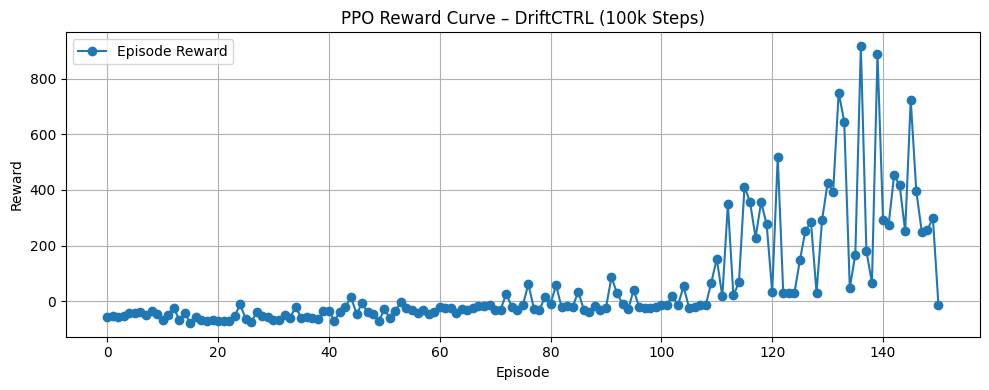

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# Load reward data from monitor log
reward_data = pd.read_csv("../logs/ppo_monitor.csv", skiprows=1)

# Plot episode reward
plt.figure(figsize=(10, 4))
plt.plot(reward_data["r"], marker="o", linestyle="-", label="Episode Reward")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("PPO Reward Curve – DriftCTRL (100k Steps)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

## MP4 Rollout

### record_video() function

In [7]:
import gymnasium as gym
import imageio
import numpy as np
import os

def record_video(env_id, model, video_length=2000, prefix="", output_dir="../videos"):
    os.makedirs(output_dir, exist_ok=True)
    env = gym.make(env_id, render_mode="rgb_array")
    obs, _ = env.reset()
    
    frames = []
    for _ in range(video_length):
        action, _ = model.predict(obs)
        obs, _, terminated, truncated, _ = env.step(action)
        frames.append(env.render())
        if terminated or truncated:
            obs, _ = env.reset()

    filename = os.path.join(output_dir, f"{prefix}_driftctrl.mp4")
    imageio.mimsave(filename, frames, fps=30)
    env.close()
    return filename

## Recording the PPO Agent

In [8]:
from stable_baselines3 import PPO

# Load the trained PPO model
model = PPO.load("../models/ppo_driftctrl")

# Record video
video_path = record_video("CarRacing-v3", model, video_length=3000, prefix="ppo")

print(f"Video saved to: {video_path}")

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Video saved to: ../videos\ppo_driftctrl.mp4


## Displaying the MP4

In [9]:
from IPython.display import Video

Video("../videos/ppo_driftctrl.mp4", width=720)